In [38]:
import datetime as dt
from river import time_series
import pandas as pd
from river import preprocessing
# Load the CSV data into a pandas DataFrame
df = pd.read_csv('merged_data.csv')

# Assume 'DateTime' is the column in your DataFrame that contains the date and time information
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index of the DataFrame
df.set_index('DateTime', inplace=True)

# Now 'time_series' has a DatetimeIndex
time_series_data = df['MeanEnergyConsumption']

# Define the order parameters for the SNARIMAX model and the seasonal component
# These are just example values - you'll need to choose appropriate values based on your data
p = 1
d = 0
q = 1
sp = 1
sd = 1
sq = 1
m = 24

model = time_series.SNARIMAX(p=p, d=d, q=q, sp=sp, sd=sd, sq=sq, m=m)

# Train the model
for t, y in time_series_data.items():
    print(f'{t}: {y:.3f}')
    # Convert y to numeric, if it's not already
    y = float(y) if y else None

    # If y is not NaN, update the model
    if y is not None:
        model.learn_one(y)

# Forecast the next 24 hours
horizon = 24*7
forecast = model.forecast(horizon=horizon)
for t, y_pred in zip(range(horizon), forecast):
    print(f'{t}: {y_pred:.3f}')

2011-11-23 09:00:00: 0.355
2011-11-23 10:00:00: 0.174
2011-11-23 11:00:00: 0.134
2011-11-23 12:00:00: 0.452
2011-11-23 13:00:00: 0.288
2011-11-23 14:00:00: 0.299
2011-11-23 15:00:00: 0.224
2011-11-23 16:00:00: 0.154
2011-11-23 17:00:00: 0.257
2011-11-23 18:00:00: 0.281
2011-11-23 19:00:00: 0.343
2011-11-23 20:00:00: 0.493
2011-11-23 21:00:00: 0.388
2011-11-23 22:00:00: 0.400
2011-11-23 23:00:00: 0.266
2011-11-24 00:00:00: 0.205
2011-11-24 01:00:00: 0.300
2011-11-24 02:00:00: 0.211
2011-11-24 03:00:00: 0.159
2011-11-24 04:00:00: 0.146
2011-11-24 05:00:00: 0.117
2011-11-24 06:00:00: 0.137
2011-11-24 07:00:00: 0.174
2011-11-24 08:00:00: 0.170
2011-11-24 09:00:00: 0.143
2011-11-24 10:00:00: 0.234
2011-11-24 11:00:00: 0.189
2011-11-24 12:00:00: 0.234
2011-11-24 13:00:00: 0.214
2011-11-24 14:00:00: 0.204
2011-11-24 15:00:00: 0.222
2011-11-24 16:00:00: 0.180
2011-11-24 17:00:00: 0.279
2011-11-24 18:00:00: 0.279
2011-11-24 19:00:00: 0.380
2011-11-24 20:00:00: 0.361
2011-11-24 21:00:00: 0.361
2

In [39]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from sklearn.model_selection import train_test_split
import pandas as pd
from river import neighbors

# Assuming df is your DataFrame and 'MeanEnergyConsumption' is your target variable
df = pd.read_csv('merged_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
X = df.drop('MeanEnergyConsumption', axis=1)
y = df['MeanEnergyConsumption']

#get month and day of the week from the date time column

X['Month'] = X['DateTime'].dt.month
X['DayOfWeek'] = X['DateTime'].dt.dayofweek


#drop the date time column
X = X.drop('DateTime', axis=1)
# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the training set back to DataFrame for the model training
train_df = pd.concat([X_train, y_train], axis=1)

#save train df to a file
train_df.to_csv('train_df.csv', index=False)

# Convert the test set back to DataFrame for the model testing
test_df = pd.concat([X_test, y_test], axis=1)

model = (
    preprocessing.StandardScaler() |
    time_series.SNARIMAX(
    p = 1,
    d = 0,
    q = 1,
    sp = 0,
    sd = 1,
    sq = 1,
    m = 24,
        regressor=(
            preprocessing.StandardScaler() |
            neighbors.KNNRegressor(
            n_neighbors=8,
            aggregation_method = 'weighted_mean',
        )
        )
    )
)

# Train the model
for _, row in train_df.iterrows():
    y = row['MeanEnergyConsumption']
    exog = row.drop('MeanEnergyConsumption').to_dict()
    model.learn_one(exog, y)

# Forecast the test set
forecast = []
for _, row in test_df.iterrows():
    exog = row.drop('MeanEnergyConsumption').to_dict()
    y_pred = model.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
    forecast.append(y_pred[0])  # y_pred is a list, get the first (and only) element
    #model.learn_one(exog, y_pred[0])

forecast_list = []
for t, y_pred in zip(range(len(forecast)), forecast):
    print(f'{t}: {y_pred:.3f}')
    #add all values to a list
    forecast_list.append(y_pred)
train_df.head()


0: 0.224
1: 0.173
2: 0.130
3: 0.162
4: 0.214
5: 0.187
6: 0.200
7: 0.249
8: 0.160
9: 0.156
10: 0.194
11: 0.188
12: 0.200
13: 0.184
14: 0.196
15: 0.205
16: 0.226
17: 0.222
18: 0.168
19: 0.225
20: 0.170
21: 0.167
22: 0.179
23: 0.229
24: 0.230
25: 0.181
26: 0.181
27: 0.206
28: 0.130
29: 0.234
30: 0.072
31: 0.231
32: 0.163
33: 0.239
34: 0.158
35: 0.240
36: 0.255
37: 0.232
38: 0.258
39: 0.160
40: 0.179
41: 0.186
42: 0.150
43: 0.202
44: 0.252
45: 0.274
46: 0.189
47: 0.209
48: 0.199
49: 0.243
50: 0.170
51: 0.231
52: 0.233
53: 0.151
54: 0.212
55: 0.168
56: 0.227
57: 0.156
58: 0.281
59: 0.277
60: 0.139
61: 0.217
62: 0.226
63: 0.198
64: 0.194
65: 0.234
66: 0.149
67: 0.245
68: 0.199
69: 0.143
70: 0.162
71: 0.208
72: 0.237
73: 0.313
74: 0.196
75: 0.176
76: 0.271
77: 0.235
78: 0.164
79: 0.215
80: 0.192
81: 0.165
82: 0.147
83: 0.211
84: 0.175
85: 0.212
86: 0.137
87: 0.167
88: 0.169
89: 0.256
90: 0.230
91: 0.189
92: 0.189
93: 0.136
94: 0.181
95: 0.187
96: 0.164
97: 0.194
98: 0.168
99: 0.215
100: 0.143

,temperature_2m,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,sunshine_duration,Month,DayOfWeek,MeanEnergyConsumption
5513,13.80,0.0,92.100006,65.0,56.0,0.0,0.0,0.0,7,1,0.100744
14915,17.25,0.0,100.000000,81.0,62.0,0.0,0.0,0.0,8,0,0.247018
14910,21.40,0.3,100.000000,100.0,99.0,35.0,1.0,3600.0,8,0,0.163052
17897,6.60,0.0,51.900000,8.0,26.0,97.0,0.0,0.0,12,6,0.162039
7220,7.45,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,9,2,0.110134


In [47]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from sklearn.model_selection import train_test_split
import pandas as pd
from river import neighbors

# Assuming df is your DataFrame and 'MeanEnergyConsumption' is your target variable
df = pd.read_csv('merged_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
#get date range 
start_date = df["DateTime"].min()
end_date = df['DateTime'].max()

X = df.drop('MeanEnergyConsumption', axis=1)
y = df['MeanEnergyConsumption']

# Get month and day of the week from the date time column
X['Month'] = X['DateTime'].dt.month
X['DayOfWeek'] = X['DateTime'].dt.dayofweek

# Drop the date time column
X = X.drop('DateTime', axis=1)

X_train = X
y_train = y

# Convert the training set back to DataFrame for the model training
train_df = pd.concat([X_train, y_train], axis=1)


model = (
    preprocessing.StandardScaler() |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=1,
        sp=0,
        sd=1,
        sq=1,
        m=24,
        regressor=(
            preprocessing.StandardScaler() |
            neighbors.KNNRegressor(
                n_neighbors=8,
                aggregation_method='weighted_mean',
            )
        )
    )
)

# Train the model
list_of_predictions = []
for _, row in train_df.iterrows():
    y = row['MeanEnergyConsumption']
    exog = row.drop('MeanEnergyConsumption').to_dict()
    model.learn_one(exog, y)
    forecast = model.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
    list_of_predictions.append(forecast[0])

# Forecast the next week
exog_next_week = test_df.iloc[:24*7].drop('MeanEnergyConsumption', axis=1).to_dict('records')
forecast = model.forecast(horizon=24*7, xs=exog_next_week)

for t, y_pred in zip(range(len(forecast)), forecast):
    print(f'{t}: {y_pred:.3f}')




0: 0.172
1: 0.137
2: 0.124
3: 0.116
4: 0.112
5: 0.137
6: 0.192
7: 0.241
8: 0.218
9: 0.205
10: 0.202
11: 0.197
12: 0.207
13: 0.195
14: 0.198
15: 0.204
16: 0.235
17: 0.306
18: 0.363
19: 0.349
20: 0.340
21: 0.303
22: 0.253
23: 0.219
24: 0.173
25: 0.139
26: 0.122
27: 0.117
28: 0.113
29: 0.137
30: 0.192
31: 0.237
32: 0.206
33: 0.197
34: 0.197
35: 0.195
36: 0.207
37: 0.195
38: 0.198
39: 0.204
40: 0.235
41: 0.306
42: 0.365
43: 0.351
44: 0.341
45: 0.306
46: 0.259
47: 0.225
48: 0.180
49: 0.140
50: 0.126
51: 0.121
52: 0.116
53: 0.140
54: 0.199
55: 0.240
56: 0.213
57: 0.196
58: 0.200
59: 0.198
60: 0.209
61: 0.189
62: 0.196
63: 0.204
64: 0.235
65: 0.306
66: 0.366
67: 0.352
68: 0.341
69: 0.306
70: 0.259
71: 0.225
72: 0.178
73: 0.142
74: 0.128
75: 0.123
76: 0.115
77: 0.138
78: 0.195
79: 0.238
80: 0.210
81: 0.195
82: 0.198
83: 0.197
84: 0.208
85: 0.190
86: 0.197
87: 0.205
88: 0.233
89: 0.306
90: 0.366
91: 0.352
92: 0.341
93: 0.306
94: 0.258
95: 0.225
96: 0.177
97: 0.141
98: 0.129
99: 0.124
100: 0.117

In [48]:
#plot the predictions
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plot the actual values

#print number of actual values
print(len(y_test.values))
print(len(list_of_predictions))



start_date =  train_df['DateTime'].min()
end_date =  train_df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')
#remove the first timestamp
timestamps = timestamps[1:]



fig, ax = plt.subplots()
ax.plot_date(mdates.date2num(train_df['DateTime']), train_df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
ax.plot_date(mdates.date2num(timestamps), list_of_predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')


1987
19864


KeyError: 'DateTime'

2014-02-28 00:00:00


C:\Users\Stijn\AppData\Local\Temp\ipykernel_334624\3689406512.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start=start_date, periods=horizon, freq='H'), forecast, label='Forecast')


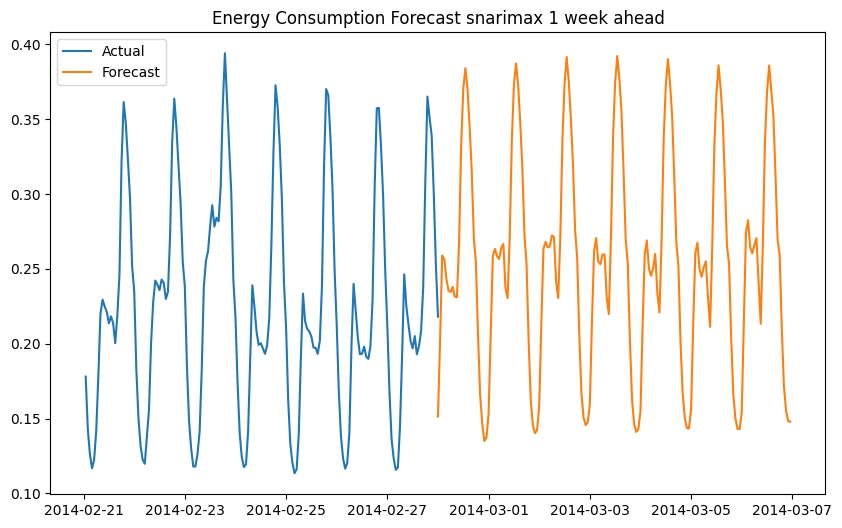

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_series_data[-24*7:], label='Actual')

#set start date for forecast
start_date = time_series_data.index[-1]

#only keep the last week of data from the forecast
forecast_list = forecast_list[-24*7:]


print(start_date)


plt.plot(pd.date_range(start=start_date, periods=horizon, freq='H'), forecast, label='Forecast')
plt.legend()
#set title
plt.title('Energy Consumption Forecast snarimax 1 week ahead')
plt.show()